In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
MODELS = [
    'CustomCNN',
    'PretrainedAlexNet',
    'PretrainedResNet',
    'PretrainedVGG16',
    'ResNetBasedModelFor32x32Images',
    'VGG16BasedModelFor32x32Images',
    'WideModel'
]

In [3]:
grouped_experiments = {model: {'data_augmented': [], 'data_not_augmented': []} for model in MODELS}
experiment_list = os.listdir('../checkpoints/')

for experiment in experiment_list:
    splitted = experiment.split('_')
    model, seed, augmentation = splitted[0], splitted[2], splitted[-1] 
    
    augmentation = 'data_augmented' if augmentation == 'True' else 'data_not_augmented'
    grouped_experiments[model][augmentation].append(experiment)

In [4]:
def concatenate_csv_files(model, paths, path_to_experiments):
    res = pd.DataFrame()
    for path in paths:
        splitted = path.split('_')
        seed = splitted[2]
        augmentation = splitted[-1]
        csv_file = path_to_experiments / path / f"{model}_{seed}.csv"

        df = pd.read_csv(csv_file)
        df['Seed'] = seed
        df['Augmentation'] = augmentation
        df['Model'] = model
        df.rename(columns={"Unnamed: 0": "Epoch"}, inplace=True)
        
        if res.shape[0] > 0:
            res = pd.concat([res, df])
        else:
            res = df
    return res

def plot_and_save_loss_and_acc_over_seed(df, path):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    
    num_epochs = len(df['Epoch'].unique())

    train_loss_avg = df.groupby('Epoch')['Train Loss'].mean()
    val_loss_avg = df.groupby('Epoch')['Val Loss'].mean()
    train_acc_avg = df.groupby('Epoch')['Train Accuracy'].mean()
    val_acc_avg = df.groupby('Epoch')['Val Accuracy'].mean()
    
    train_color = '#007bff'
    val_color = '#ff6347'
    
    for seed, group in df.groupby('Seed'):
        axes[0].plot(group['Epoch'], group['Train Loss'], color=train_color, alpha=0.3)
        axes[0].plot(group['Epoch'], group['Val Loss'], color=val_color, alpha=0.3)

        axes[1].plot(group['Epoch'], group['Train Accuracy'], color=train_color, alpha=0.3)
        axes[1].plot(group['Epoch'], group['Val Accuracy'], color=val_color, alpha=0.3)

    # train and val loss averages
    axes[0].plot(train_loss_avg.index, train_loss_avg.values, color=train_color)
    axes[0].plot(val_loss_avg.index, val_loss_avg.values, color=val_color)

    # train and val accuracies averages
    axes[1].plot(train_acc_avg.index, train_acc_avg.values, color=train_color)
    axes[1].plot(val_acc_avg.index, val_acc_avg.values, color=val_color)
    
    axes[0].legend(['Train', 'Val'], loc='lower left')
    axes[1].legend(['Train', 'Val'], loc='lower right')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')

    model_name = df.Model.unique()[0]
    augmentation = df.Augmentation.unique()[0]
    plt.suptitle(f'Model: {model_name} | Augmentation: {augmentation} | Number of Epochs: {num_epochs}', fontsize=14)
    plt.tight_layout(rect=[0, 0.01, 0.99, 0.99])
    plt.savefig(path / 'loss_acc_plots.png')
    df.to_csv(path / 'results.csv', index=False)

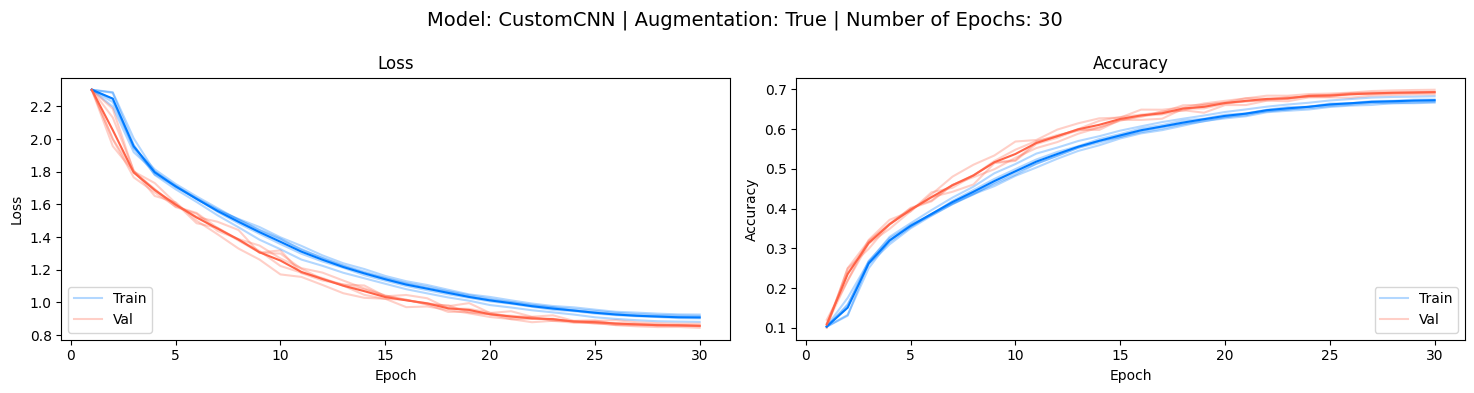

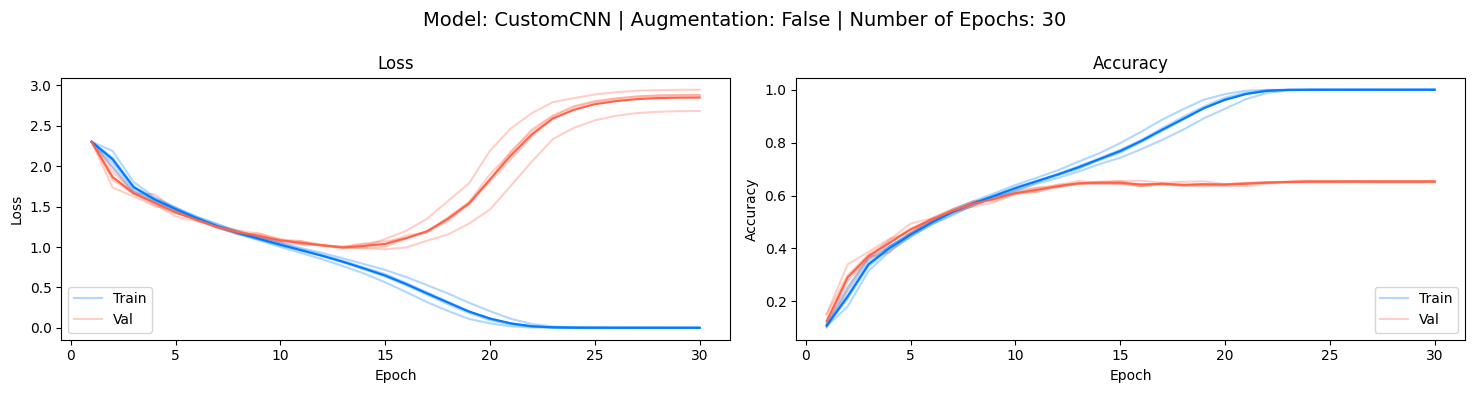

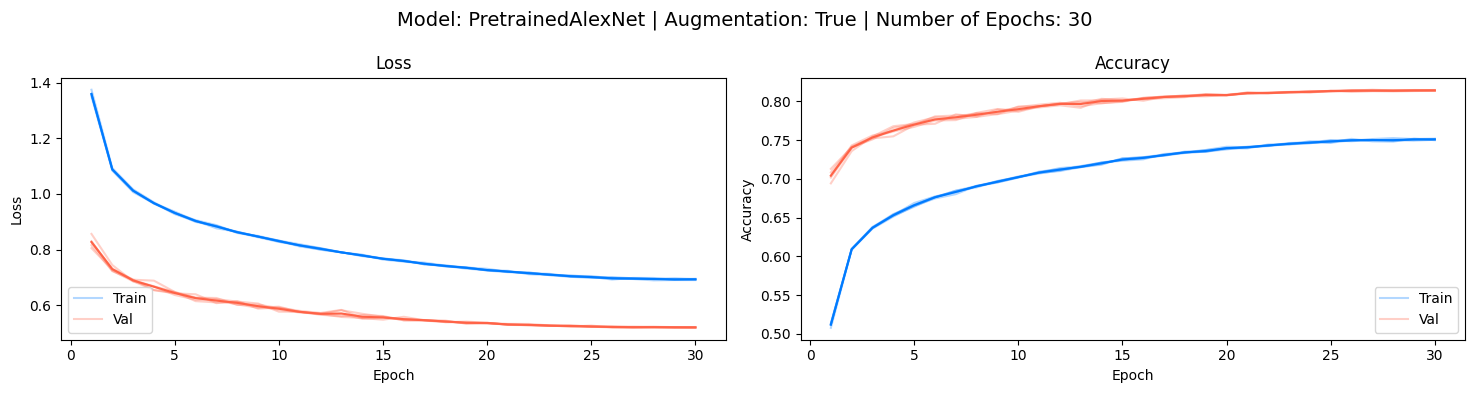

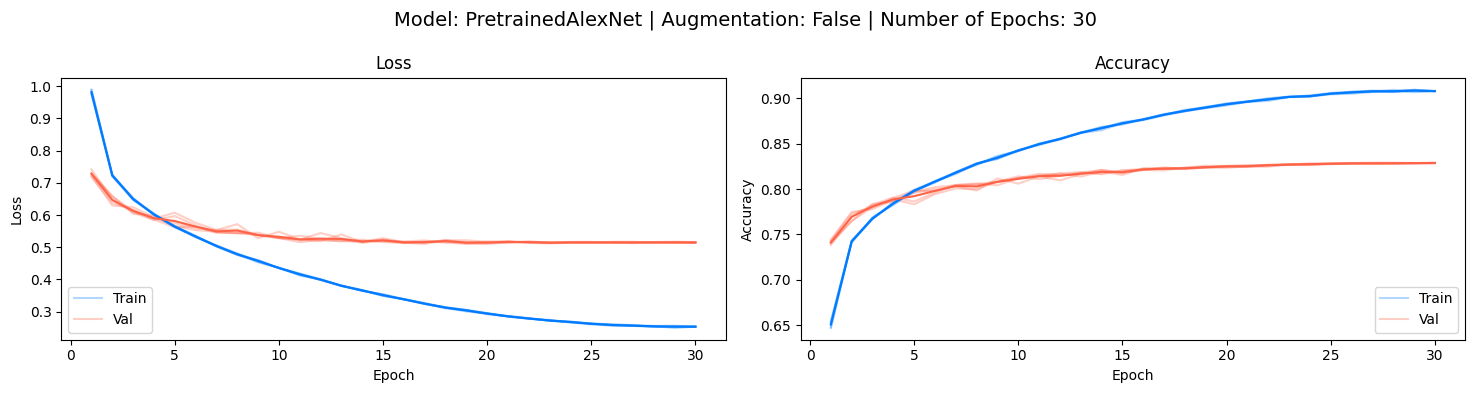

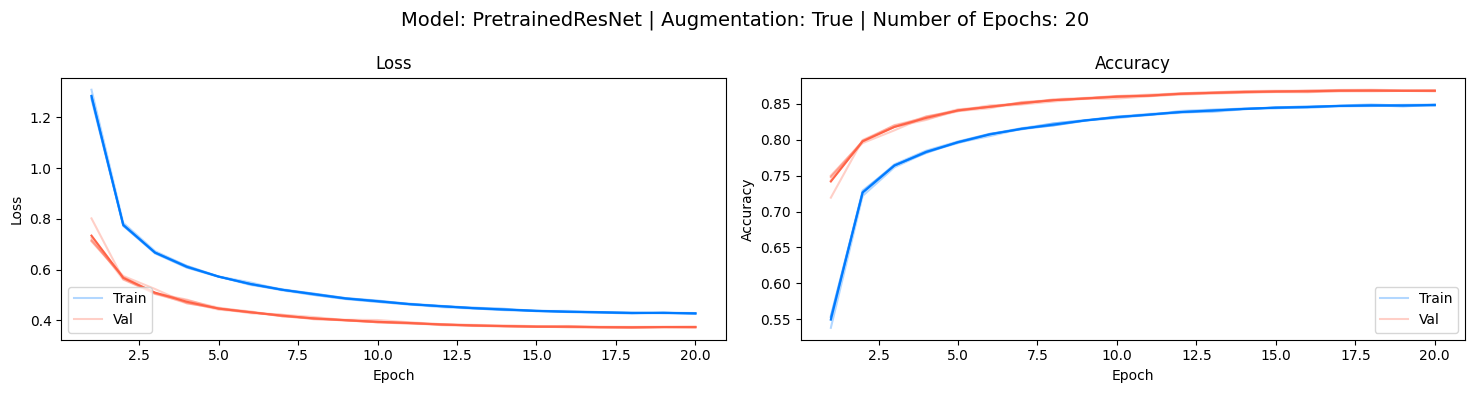

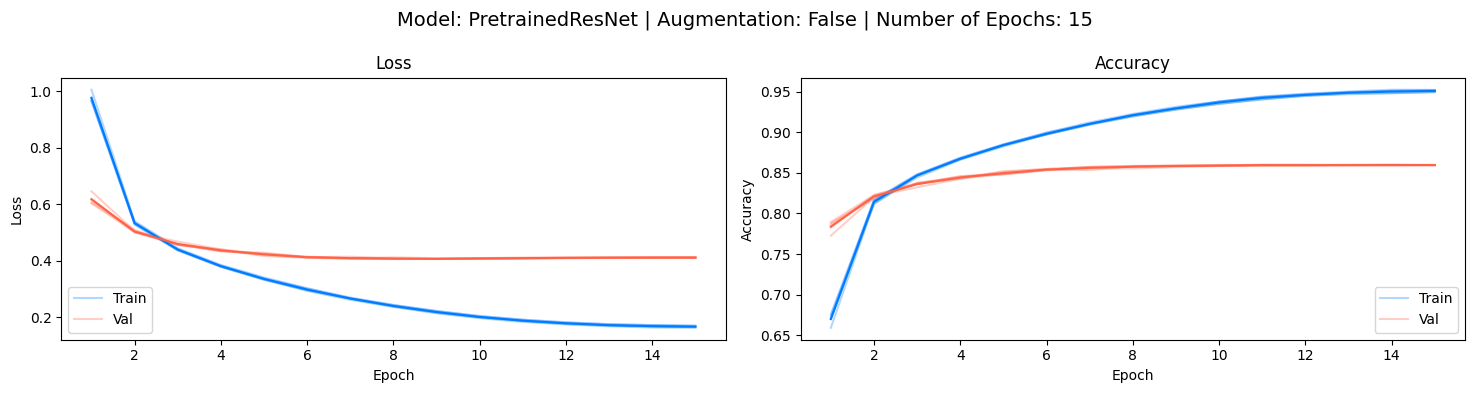

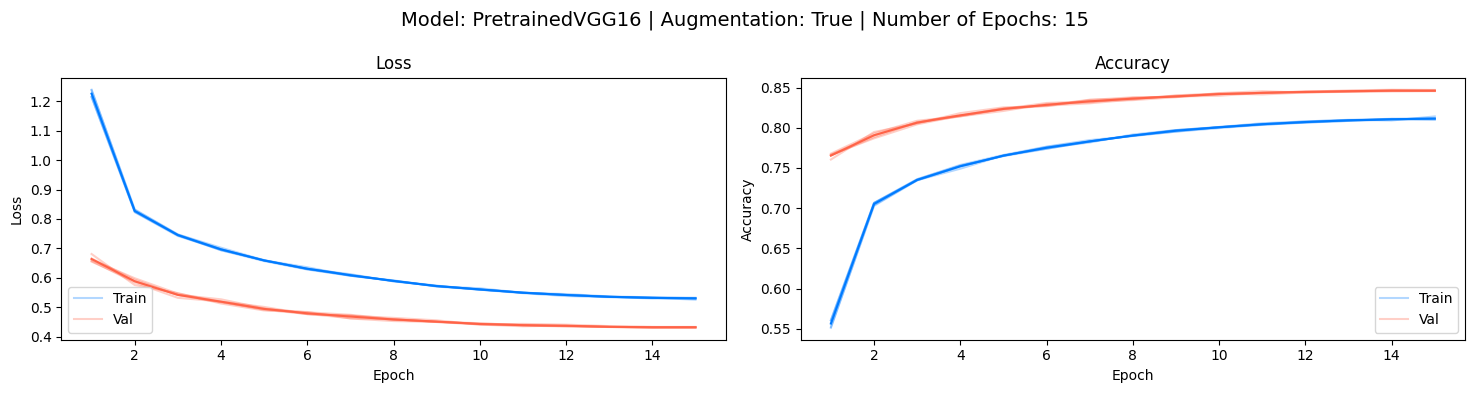

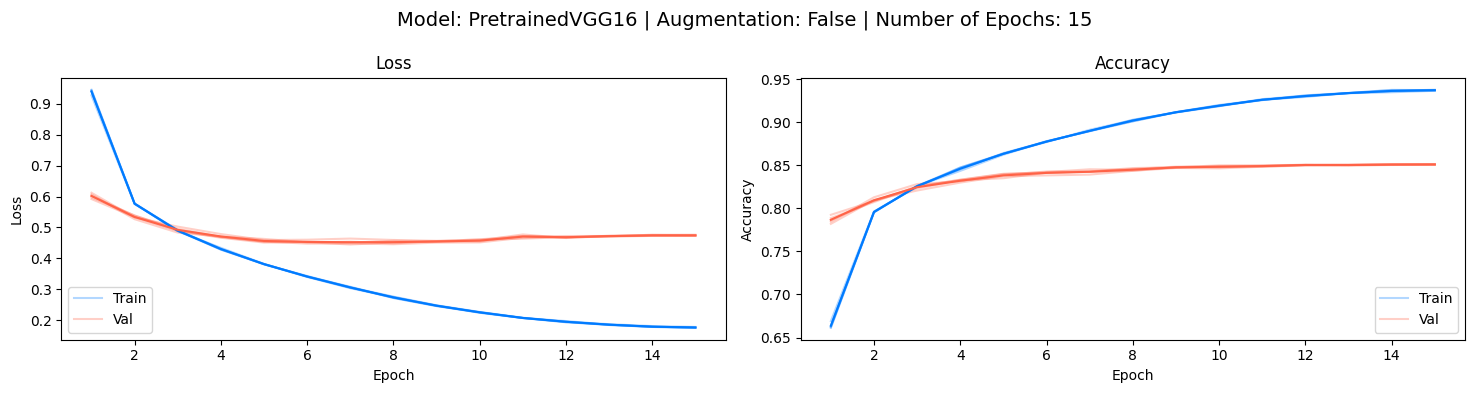

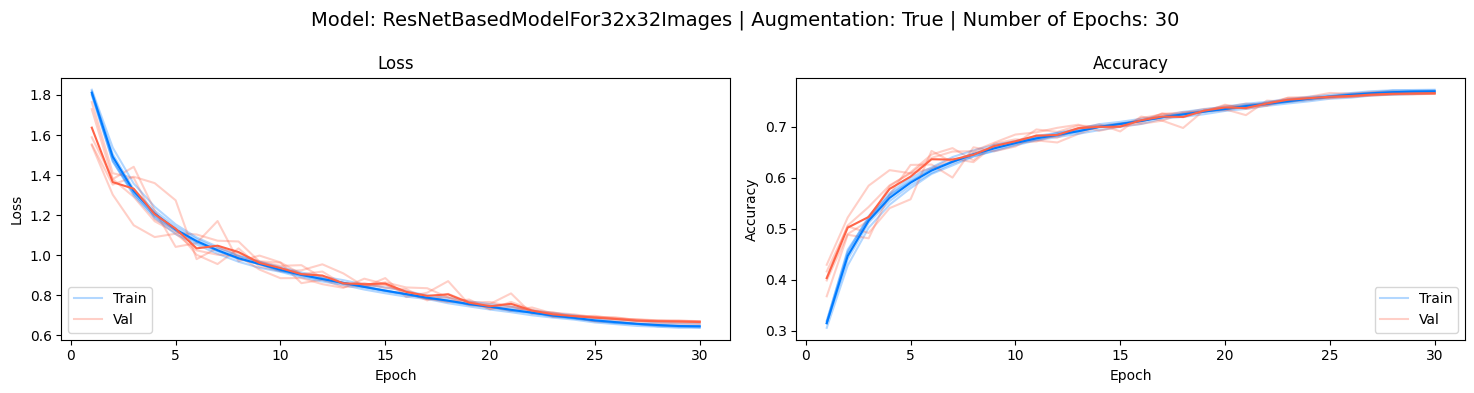

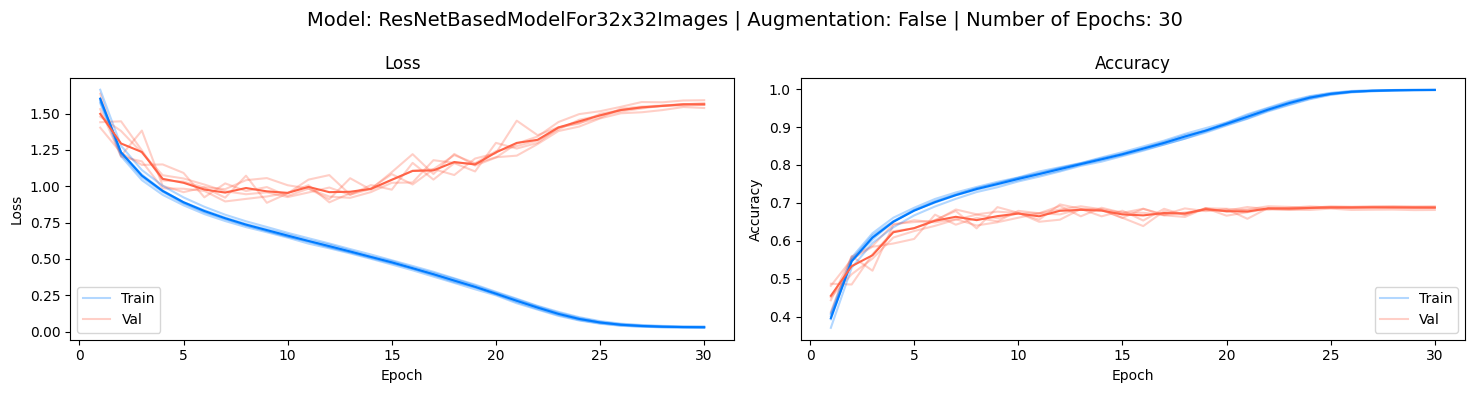

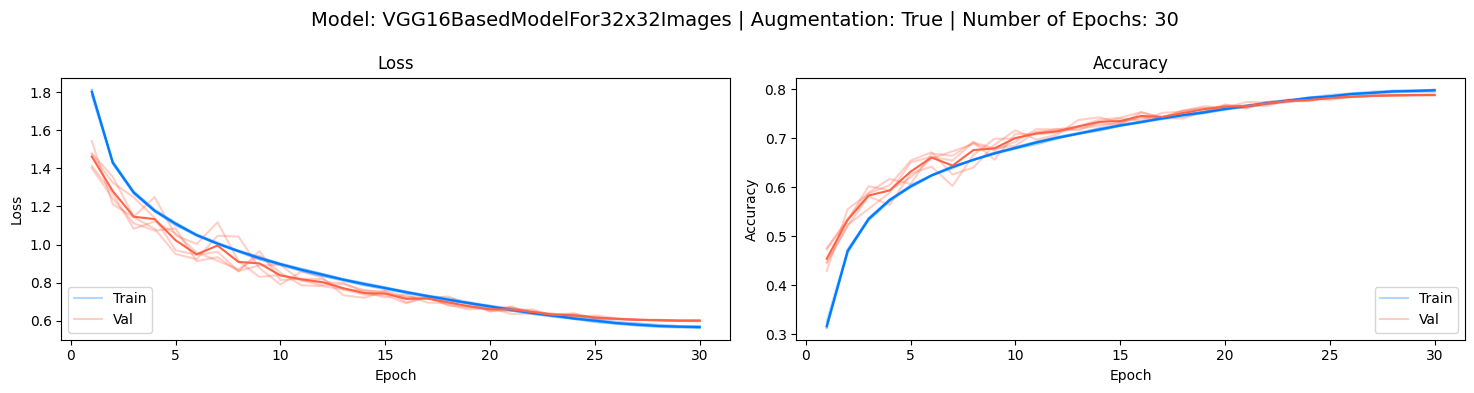

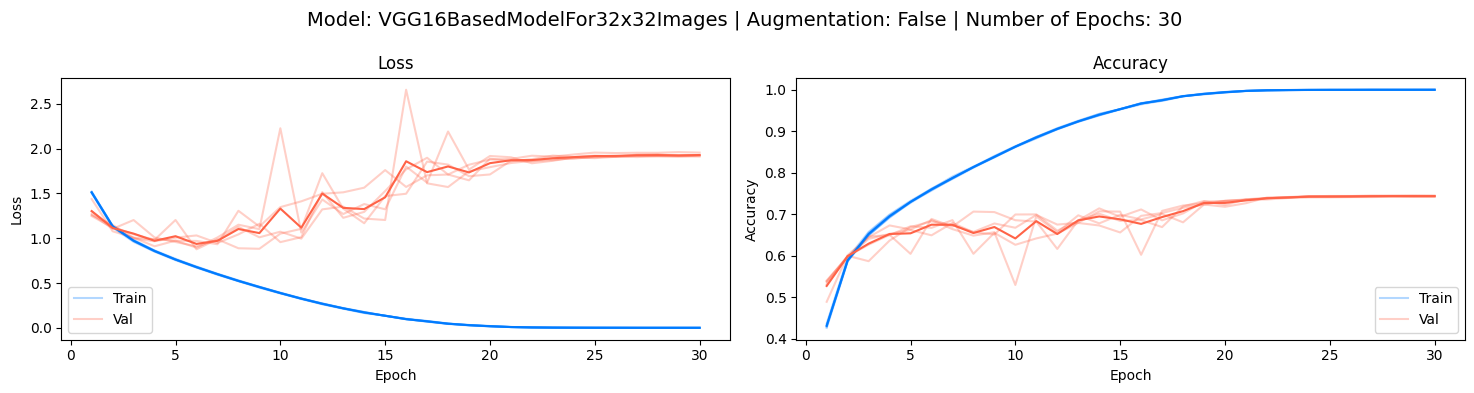

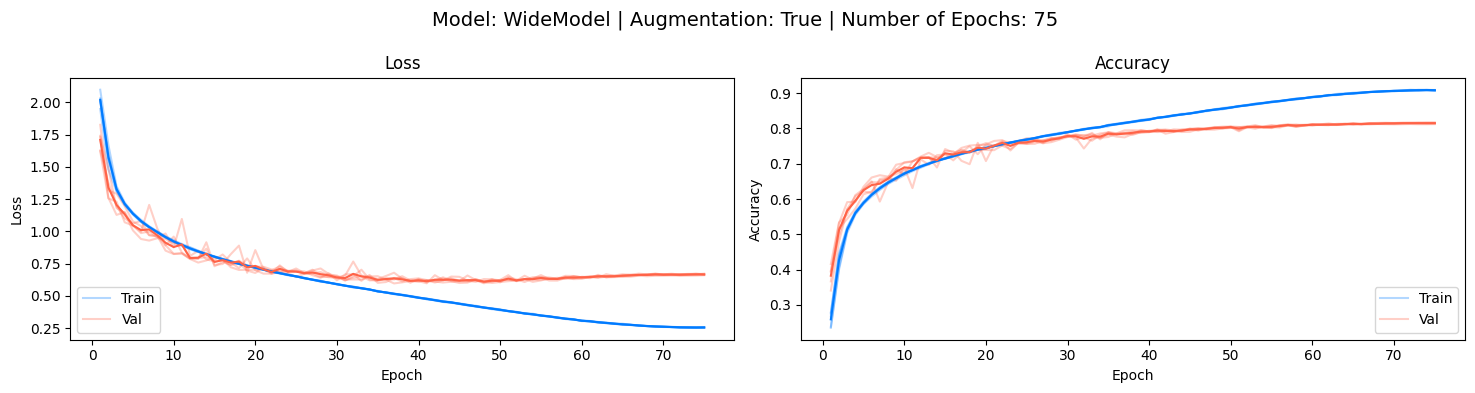

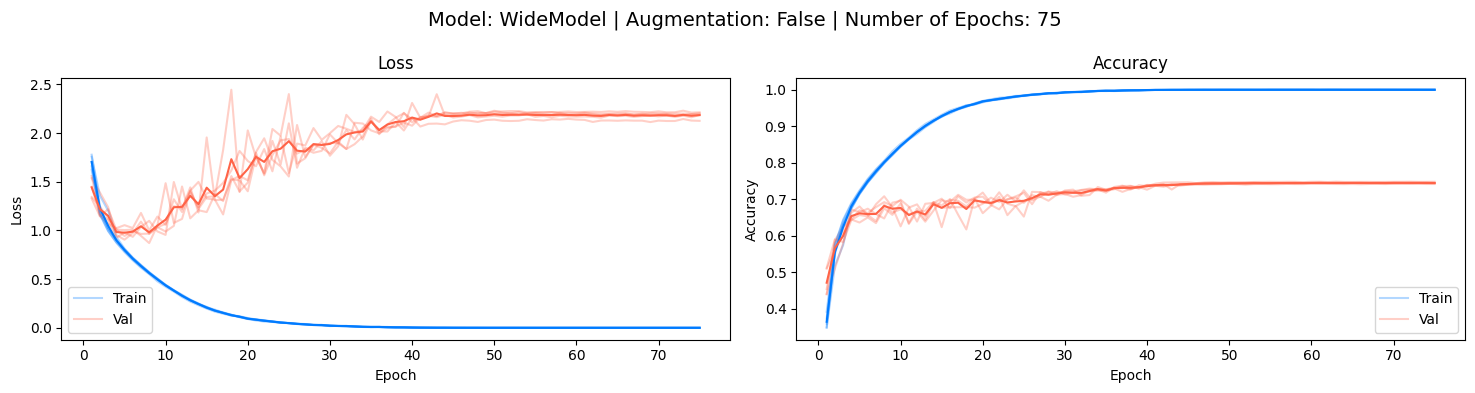

In [5]:
concatenated_dfs = {}

aggregated_results_path = Path('aggregated_results')

if not os.path.exists(aggregated_results_path):
    os.makedirs(aggregated_results_path)

for model, details in grouped_experiments.items():
    for augmentation_type, paths in details.items():
        augmentation = 'True' if augmentation_type == 'data_augmented' else 'False'
        path_to_save = aggregated_results_path / f"{model}_augmentation_{augmentation}"
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        df = concatenate_csv_files(model, paths, Path('../checkpoints/'))
        plot_and_save_loss_and_acc_over_seed(df, path_to_save)